DL model to classify pokemons by types 

Dataset source: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types 

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras import models
from keras.applications import VGG16 
from keras import layers
from keras import models
from keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [3]:
#load csv and add filenames
df = pd.read_csv("pokemon.csv")
original_dataset = "images/images/"
filenames = os.listdir(original_dataset)
filenames_dict = {}
for filename in filenames:
	filenames_dict[filename.split(".")[0]] = filename
df = df.assign(Filename=df.Name.map(filenames_dict))
df

,Name,Type1,Type2,Filename
0,bulbasaur,Grass,Poison,bulbasaur.png
1,ivysaur,Grass,Poison,ivysaur.png
2,venusaur,Grass,Poison,venusaur.png
3,charmander,Fire,NaN,charmander.png
4,charmeleon,Fire,NaN,charmeleon.png
...,...,...,...,...
804,stakataka,Rock,Steel,stakataka.jpg
805,blacephalon,Fire,Ghost,blacephalon.jpg
806,zeraora,Electric,NaN,zeraora.jpg
807,meltan,Steel,NaN,meltan.jpg


In [4]:
#Get valid types (any that has more than 50 occurrences)
# df.groupby("Type1")["Type1"].count().sort_values(ascending=False)
valid_types = list(df.groupby("Type1")["Type1"].count().loc[lambda x: x > 70].index)
print(f"Valid types: {valid_types}")

Valid types: ['Bug', 'Grass', 'Normal', 'Water']


In [5]:
#Fitler pokemon by valid types
valid_pokemon = df[df["Type1"].isin(valid_types)];
valid_pokemon = valid_pokemon[["Name", "Type1", "Filename"]]
valid_pokemon.reset_index(inplace=True)
valid_pokemon

,index,Name,Type1,Filename
0,0,bulbasaur,Grass,bulbasaur.png
1,1,ivysaur,Grass,ivysaur.png
2,2,venusaur,Grass,venusaur.png
3,6,squirtle,Water,squirtle.png
4,7,wartortle,Water,wartortle.png
...,...,...,...,...
364,786,tapu-bulu,Grass,tapu-bulu.jpg
365,787,tapu-fini,Water,tapu-fini.jpg
366,793,buzzwole,Bug,buzzwole.jpg
367,794,pheromosa,Bug,pheromosa.jpg


In [6]:
#Data split
train, validation, test = np.split(valid_pokemon, [int(0.6*len(valid_pokemon)), int(0.8*len(valid_pokemon))])    

In [7]:
#Create directories
base_dir = "pokemon/"
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, "train")
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, "validation")
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, "test")
os.makedirs(test_dir, exist_ok=True)

In [8]:


for type in valid_types:
	new_dir = os.path.join(train_dir, type)
	os.makedirs(new_dir, exist_ok=True)

for type in valid_types:
	new_dir = os.path.join(validation_dir, type)
	os.makedirs(new_dir, exist_ok=True)

for type in valid_types:
	new_dir = os.path.join(test_dir, type)
	os.makedirs(new_dir, exist_ok=True)

for index, row in train.iterrows():
	src = os.path.join(original_dataset, row["Filename"])
	folder = os.path.join(train_dir, row["Type1"])
	dst = os.path.join(folder, row["Filename"])
	shutil.copyfile(src, dst)

for index, row in validation.iterrows():
	src = os.path.join(original_dataset, row["Filename"])
	folder = os.path.join(validation_dir, row["Type1"])
	dst = os.path.join(folder, row["Filename"])
	shutil.copyfile(src, dst)

for index, row in test.iterrows():
	src = os.path.join(original_dataset, row["Filename"])
	folder = os.path.join(test_dir, row["Type1"])
	dst = os.path.join(folder, row["Filename"])
	shutil.copyfile(src, dst)


In [9]:
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(train_dir, color_mode='rgb', class_mode="categorical", target_size=(240, 240))
validation_generator = datagen.flow_from_directory(validation_dir, color_mode='rgb', class_mode="categorical", target_size=(240, 240))
test_generator = datagen.flow_from_directory(test_dir, class_mode="categorical", color_mode='rgb', target_size=(240, 240))

Found 221 images belonging to 4 classes.
Found 74 images belonging to 4 classes.
Found 74 images belonging to 4 classes.


In [10]:
model1 = models.Sequential()
model1.add(layers.Conv2D(16, (3,3), activation="relu", input_shape=(240, 240, 3)))
model1.add(layers.MaxPooling2D(3,3))
model1.add(layers.Conv2D(32, (3,3), activation="relu"))
model1.add(layers.Flatten())
model1.add(layers.Dense(8, activation="relu"))
model1.add(layers.Dense(4, activation="softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 189728)            0         
                                                                 
 dense (Dense)               (None, 8)                 1517832   
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                        

In [11]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [13]:
history1 = model1.fit_generator(train_generator, epochs=10, verbose=2, validation_data=validation_generator)

Epoch 1/10
7/7 - 4s - loss: 1.3621 - acc: 0.1991 - val_loss: 1.3865 - val_acc: 0.2432 - 4s/epoch - 619ms/step
Epoch 2/10
7/7 - 4s - loss: 1.3874 - acc: 0.1810 - val_loss: 1.3863 - val_acc: 0.2432 - 4s/epoch - 522ms/step
Epoch 3/10
7/7 - 4s - loss: 1.3872 - acc: 0.2308 - val_loss: 1.3860 - val_acc: 0.2973 - 4s/epoch - 620ms/step
Epoch 4/10
7/7 - 5s - loss: 1.3866 - acc: 0.2851 - val_loss: 1.3857 - val_acc: 0.2973 - 5s/epoch - 673ms/step
Epoch 5/10
7/7 - 7s - loss: 1.3860 - acc: 0.2851 - val_loss: 1.3852 - val_acc: 0.2973 - 7s/epoch - 1s/step
Epoch 6/10
7/7 - 7s - loss: 1.3853 - acc: 0.2851 - val_loss: 1.3848 - val_acc: 0.2973 - 7s/epoch - 1s/step
Epoch 7/10
7/7 - 5s - loss: 1.3845 - acc: 0.2851 - val_loss: 1.3843 - val_acc: 0.2973 - 5s/epoch - 767ms/step
Epoch 8/10
7/7 - 5s - loss: 1.3838 - acc: 0.2851 - val_loss: 1.3839 - val_acc: 0.2973 - 5s/epoch - 715ms/step
Epoch 9/10
7/7 - 5s - loss: 1.3829 - acc: 0.2851 - val_loss: 1.3834 - val_acc: 0.2973 - 5s/epoch - 652ms/step
Epoch 10/10
7/7 

In [56]:
model1.save("model1.h5")

In [53]:
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

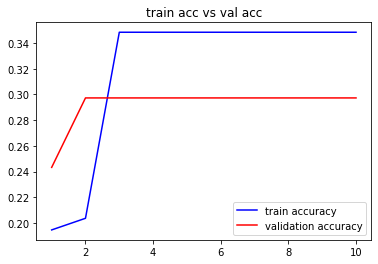

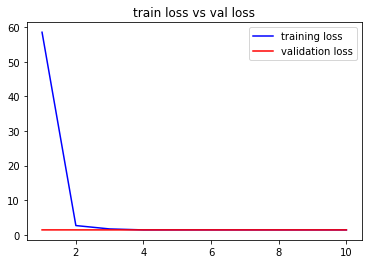

In [54]:
epochs = range(1, len(acc1)+1)

plt.plot(epochs,acc1,'b',label='train accuracy')
plt.plot(epochs,val_acc1, 'r', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss1, 'b', label ='training loss')
plt.plot(epochs,val_loss1, 'r', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [55]:
test_loss1, test_acc1 = model1.evaluate_generator(test_generator)
test_acc1

0.20270270109176636

In [25]:
conv_base = VGG16(weights=None, include_top=False, input_shape=(240, 240, 3))

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(16, activation="relu"))
model2.add(layers.Dense(4, activation="softmax"))

conv_base.trainable = False

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 16)                401424    
                                                                 
 dense_9 (Dense)             (None, 4)                 68        
                                                                 
Total params: 15,116,180
Trainable params: 401,492
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [28]:
history2 = model2.fit_generator(train_generator, epochs=10, verbose=2, validation_data=validation_generator)

Epoch 1/10
7/7 - 91s - loss: 1.3775 - acc: 0.3303 - val_loss: 1.3854 - val_acc: 0.3784 - 91s/epoch - 13s/step
Epoch 2/10
7/7 - 101s - loss: 1.3698 - acc: 0.3665 - val_loss: 1.3767 - val_acc: 0.2973 - 101s/epoch - 14s/step
Epoch 3/10
7/7 - 96s - loss: 1.3603 - acc: 0.3484 - val_loss: 1.3767 - val_acc: 0.2973 - 96s/epoch - 14s/step
Epoch 4/10
7/7 - 89s - loss: 1.3575 - acc: 0.3846 - val_loss: 1.3639 - val_acc: 0.3784 - 89s/epoch - 13s/step
Epoch 5/10
7/7 - 92s - loss: 1.3385 - acc: 0.4299 - val_loss: 1.3742 - val_acc: 0.3378 - 92s/epoch - 13s/step
Epoch 6/10
7/7 - 89s - loss: 1.3236 - acc: 0.4163 - val_loss: 1.3666 - val_acc: 0.4324 - 89s/epoch - 13s/step
Epoch 7/10
7/7 - 90s - loss: 1.3073 - acc: 0.4570 - val_loss: 1.4309 - val_acc: 0.3108 - 90s/epoch - 13s/step
Epoch 8/10
7/7 - 96s - loss: 1.3151 - acc: 0.4299 - val_loss: 1.3678 - val_acc: 0.3649 - 96s/epoch - 14s/step
Epoch 9/10
7/7 - 90s - loss: 1.2979 - acc: 0.4570 - val_loss: 1.3732 - val_acc: 0.3649 - 90s/epoch - 13s/step
Epoch 10

In [33]:
model2.save("model2.h5")

In [29]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

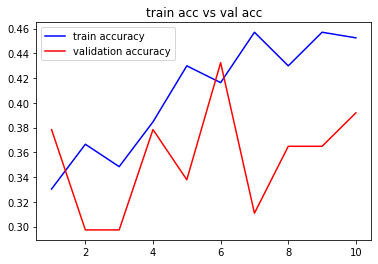

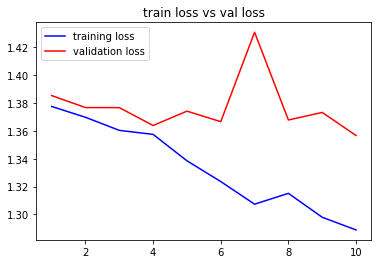

In [30]:
epochs = range(1, len(acc2)+1)

plt.plot(epochs,acc2,'b',label='train accuracy')
plt.plot(epochs,val_acc2, 'r', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss2, 'b', label ='training loss')
plt.plot(epochs,val_loss2, 'r', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [31]:
test_loss, test_acc = model2.evaluate_generator(test_generator)
test_acc

0.2567567527294159

In [29]:
model2 = models.load_model("model2.h5")

1/1 [==============================] - 0s 330ms/step
Normal


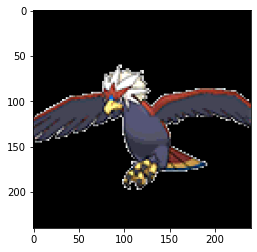

In [30]:
img = load_img("./pokemon/test/Normal/braviary.png", target_size=(240, 240))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

prediction = model2.predict(img_tensor)
print(valid_types[np.argmax([prediction])])
plt.imshow(img_tensor[0])
plt.show()


1/1 [==============================] - 0s 191ms/step
Normal


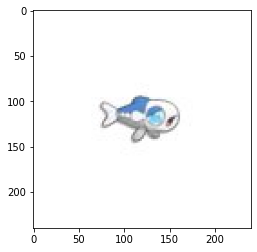

In [43]:
img = load_img("./pokemon/test/Water/wishiwashi-solo.jpg", target_size=(240, 240))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

prediction = model2.predict(img_tensor)
print(valid_types[np.argmax([prediction])])
plt.imshow(img_tensor[0])
plt.show()